<a href="https://colab.research.google.com/github/tayfununal/hamiltonian_ex/blob/main/hamiltonian_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [155]:
#simplektik euler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

plt.style.use('seaborn-poster')

#np.random.seed(1)
#tf.random.set_seed(1)

In [156]:
class Hamiltonian:

  def __init__(self, T, V, h=0.01, initial_point=[0., 1.]):
    self.T = T
    self.V = V
    self.h = h
    self.initial_point = initial_point

    self.z, self.t = self.symplectic_euler()

    self.model = self.NN(input =1, output=2, hidden_layer=20, neuron=64, activation="relu", energy_loss=None)
    self.model_train = self.train(model=self.model, input=self.t, target=self.z, learning_rate=0.0003, loss="mse", batch_size=100000, epochs=1000)

    self.energy_model = self.NN(input= 1,output=2, hidden_layer=20, neuron=64, activation=tf.math.sin, energy_loss=self.custom_loss)
        
    # Parametreleri atama ve veri arttırma
    self.energy_model.set_weights(self.model_train.get_weights())
    t_created = np.arange(0, 2*np.pi, 0.0001)
    target_created = self.model_train(t_created)

    self.energy_model_train = self.train(model=self.energy_model, input=t_created, target=target_created, learning_rate=0.0003, loss=self.custom_loss, batch_size=100000, epochs=1000)
  # Hamiltonian Function
  def H(self, q, p):
    return T(p) + V(q)

  # Derivative of Potential Energy
  def dV(self, q_0=tf.constant(1.0)):
    q_0 = tf.constant(q_0)
    with tf.GradientTape() as g:
      g.watch(q_0)
      y = self.V(q_0)
    return g.gradient(y, q_0)

  # Derivative of Kinetic Energy
  def dT(self, p_0=tf.constant(1.0)):
    p_0 = tf.constant(p_0)
    with tf.GradientTape() as g:
      g.watch(p_0)
      y = self.T(p_0)
    return g.gradient(y, p_0)

  def symplectic_euler(self):

    t = np.arange(0, 2*np.pi, self.h)

    q = np.zeros(t.shape[0])
    p = np.zeros(t.shape[0])

    q[0] = self.initial_point[0]
    p[0] = self.initial_point[1]
    
    for i in range(0, t.shape[0]-1):

      q[i + 1] = q[i] + self.h * self.dT(p[i])
      p[i + 1] = p[i] - self.h * self.dV(q[i+1])
    
    z = np.concatenate((q.reshape(-1,1), p.reshape(-1,1)) , axis=1)
    return z, t

  # Neural Network Model
  def NN(self, input =1, output=2, hidden_layer=2, neuron=32, activation="relu", energy_loss=None):
    # Neural network with MSE loss
    np.random.seed(1)
    tf.random.set_seed(1)

    inp = Input(shape=(input,), name= "Input_Layer")
    for i in range(0,hidden_layer):
      if i == 0:
        x = Dense(neuron, activation=activation, name="Hidden_Layer_{}".format(i+1))(inp)
      else:
        x = Dense(neuron, activation=activation, name="Hidden_Layer_{}".format(i+1))(x)
    x = Dense(output, name="Ourput_Layer")(x)
    

    out = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp**2)) * x

    return Model(inputs=inp, outputs=out)
  
  # Neural Network Model Compile and Fit
  def train(self, model, input, target, learning_rate=0.0003, loss="mse", batch_size=100, epochs=2000):
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss=loss)
    model.fit(x=input, y=target, epochs=epochs, batch_size=batch_size, shuffle=True, verbose=False)
    return model

  def custom_loss(self, y_true, y_pred):
    return tf.keras.losses.MSE(0.5, self.H(y_pred[None,:,0], y_pred[None, :,1])) +  0.5 * tf.keras.losses.MSE(y_true,y_pred)


In [157]:
def T(p):
  return (p**2)/2

def V(q):
  return (q**2)/2

In [158]:
hamiltonian = Hamiltonian(T, V)

In [159]:
def grand_truth_plot(h = 0.3):
  t = np.arange(0,2*np.pi,h)
  q = np.sin(t)
  p = np.cos(t)
  plt.scatter(q,p)

def pred_plot(q, p):
  plt.plot(q[:, ], p[:,], c = "red")
  plt.xlabel('q', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.ylabel('p', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.title("Phase Diagram", fontsize=17,fontweight="bold",fontname="Times New Roman")

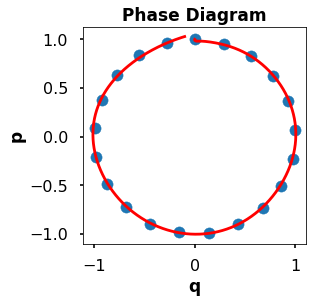

In [160]:
test_t = np.arange(0, 2*np.pi, 0.001)
prediction_energy = hamiltonian.energy_model_train(test_t)

q_energy = prediction_energy[:,0]
p_energy = prediction_energy[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q_energy, p_energy )

# Grand truth solution plot
grand_truth_plot()

plt.show()